
# <span style="color:red">**Question 1(a)  - Random Forest  Implementation**</span>

#### Reading data From File  ,  Importing Packages , Converting all the values to Float from String

In [1]:
import csv
import os
import time
import numpy as np
from math import log
from random import randrange
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import warnings
warnings.filterwarnings('ignore')
os.chdir("C:/Users/Satya/Documents/DataSets/")

#Load data set
with open("spambase.data") as f:  # #C:/Users/Satya/Documents/DataSets/spambase.data
    next(f, None)
    data = [list(line) for line in csv.reader(f, delimiter=",")]
data =np.array(data,float)
print ("Number of records: %d" % len(data))

Number of records: 4600


#### Splitting Data into Train-Test  ( 70%  Train &  30% Test )

In [2]:
#Splitting# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
training_set, test_set = train_test_split(data, test_size = 0.3, random_state = 10)

### <span style="color:purple"> Start - Decision Tree Section ( Mostly Inherited from Assignment 1)

###### Creating Function to bin Feature Values to create multiple thresholds for finding the best condition for Information Gain

In [3]:
def binned_vals(rows, col):
    values= set([row[col] for row in rows])
    return list(np.histogram([float(i) for i in values],bins=10)[1])

##### Counting class labels for a dataset or subset of data arriving at a Node

In [4]:
def class_counts(rows):
    counts = {}  
    for row in rows:
        label = row[-1]
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

#### Function for Calculating Entropy Calculation

In [5]:
def Entropy_Calc(rows):
    counts = class_counts(rows)
    entropy = 0
    for lbl in counts:
        prob_of_lbl = counts[lbl] / float(len(rows))
        entropy -= prob_of_lbl * log(prob_of_lbl, 2)
    return entropy

#### Function for Creating Evaluation Criterias for various theresholds for Any Feature

In [6]:
class Eval_Criteria:
    
    def __init__(self, column, value):
        self.column = column
        self.value = value

    def Eval(self, example):
        val = example[self.column]
        return val >= self.value

####  Function for binary univariate split for the  Data Set / Subset of Data  at a Decision Node

In [7]:
def Splits(rows, Evals_Criteria):
    right_rows, left_rows = [], []
    for row in rows:
        if Evals_Criteria.Eval(row):
            right_rows.append(row)
        else:
            left_rows.append(row)
    return right_rows, left_rows

##### Function for Calculating Information Gain 

In [8]:
def info_gain(left, right, current_entropy):
    p = float(len(left)) / (len(left) + len(right))
    return current_entropy - p * Entropy_Calc(left) - (1 - p) * Entropy_Calc(right)

#### Function for Finding Best Split or Evaluation Criteria  at each node by calculating Information Gain

In [9]:
def find_best_split(rows,n_features):
    best_gain = 0  
    best_eval_criteria = None  
    current_entropy = Entropy_Calc(rows)
     

    for col in np.random.randint(0,56, size=n_features):  
        values = binned_vals(rows,col) 

        for val in values:  # for each value
            Evals_Criteria = Eval_Criteria(col, val)
            right_rows, left_rows = Splits(rows, Evals_Criteria)
            
            if len(right_rows) == 0 or len(left_rows) == 0:
                continue

            gain = info_gain(right_rows, left_rows, current_entropy)

            if gain >= best_gain:
                best_gain, best_eval_criteria = gain, Evals_Criteria

    return best_gain, best_eval_criteria

#### Class for Prediction Node

In [10]:
class Prediction_Node:
    def __init__(self, rows):
        self.predictions = list(class_counts(rows).keys())[0]

#### Class for Decision Node

In [11]:
class Decision_Node:
    def __init__(self,
                 Evals_Criteria,
                 true_branch,
                 false_branch):
        self.Evals_Criteria = Evals_Criteria
        self.true_branch = true_branch
        self.false_branch = false_branch

#### Function for Building the Tree recursively

In [12]:
def build_tree(rows,n_features):
    gain, Evals_Criteria = find_best_split(rows,n_features)
    if gain == 0:
        return Prediction_Node(rows)
    true_rows, false_rows = Splits(rows, Evals_Criteria)
    true_branch = build_tree(true_rows,n_features)
    false_branch = build_tree(false_rows,n_features)
    return Decision_Node(Evals_Criteria, true_branch, false_branch)

#### Function for Classifying Test Data

In [13]:
def classify(row, node):
    if isinstance(node, Prediction_Node):
        return node.predictions
    if node.Evals_Criteria.Eval(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)

### <span style="color:purple"> End - Decision Tree Section ( Mostly Inherited from Assignment 1)

#### Function for Creating Random Samples with replacement  for each tree to be trained 

In [14]:
def subsample(dataset, ratio):
    sample = list()
    n_sample = round(len(dataset) * ratio)
    while len(sample) < n_sample:
        index = randrange(len(dataset))
        sample.append(dataset[index])
    return sample

#### Function for  Making a prediction with a list of bagged trees

In [15]:
def bagging_predict(trees, row):
    predictions = [classify(row,tree) for tree in trees]
    return max(set(predictions), key=predictions.count)

#### Function for implementing Random Forest Algorithm

In [16]:
def random_forest(training_set, test_set, sample_size, n_trees, n_features):
    start_time = time.time()
    trees = list()
    for i in range(n_trees):
        sample = subsample(training_set, sample_size)
        tree = build_tree(sample , n_features)
        trees.append(tree)
    predictions = [bagging_predict(trees, row) for row in test_set]
    end_time = time.time()
    return(predictions,start_time,end_time)

#### Creating a list for Actual Labels of Test set for comparison with Predicted Labels

In [17]:
y_actual= []
for row in test_set:
    y_actual.append( row[-1])

#### Accuracy of Random Forest Algorithm with 30% of Test Data

In [18]:
y_pred , start_time ,end_time = random_forest(training_set, test_set,1, 10 , 10)
print( "The Accuracy of Implemented Random Forest is :",accuracy_score(y_actual,y_pred)*100)
print("The Execution Time of the Random Forest Algorithm is %s seconds" % (end_time - start_time))

The Accuracy of Implemented Random Forest is : 94.27536231884058
The Execution Time of the Random Forest Algorithm is 41.980743169784546 seconds


#### The Above Random Forest has been created with 10 Trees and 10 Random Features for evaluating Best Split

#### Now we will evaluate Accuracy of SKlearn Random Forest Calssifier with the Same Hyperparameters

In [19]:
X_train = pd.DataFrame(training_set).iloc[:, :-1].values
y_train = pd.DataFrame(training_set).iloc[:, 57].values
X_test = pd.DataFrame(test_set).iloc[:, :-1].values
y_test = pd.DataFrame(test_set).iloc[:, 57].values

In [20]:
def Sklearnrandomforest():
    start_time = time.time()
    classifier = RandomForestClassifier(n_estimators=10, criterion= 'entropy' , max_features = 10 , random_state = 10 )
    classifier.fit(X_train , y_train)
    y_pred = classifier.predict(X_test)
    end_time = time.time()
    return(y_pred,start_time,end_time)

In [21]:
y_pred , start_time ,end_time = Sklearnrandomforest()
print ( "the Accuracy is of Sklearn Random Forest is :" , accuracy_score(y_test, y_pred))
print("The Execution Time of the Random Forest Algorithm is %s seconds" % (end_time - start_time))

the Accuracy is of Sklearn Random Forest is : 0.9485507246376812
The Execution Time of the Random Forest Algorithm is 0.08078360557556152 seconds


### <span style="color:blue">Conclusion</span>

### Based on the Above  , Below are the Accuracy and time Taken for Random Forest and Sklearn Built in Libray 

### Accuracy of  Random Forest = 94.27%   ,  Accuracy of the Scikitlearn's built-in library = 94.85%

### Time Taken of  Random Forest = 41.98 Secs   , Time Taken of the Scikitlearn's built-in library = .08 Secs



# <span style="color:red">**Question 1(b)  - Exploring Sensitivity Parameter**</span>


#### Below Code will create multiple random forests for differnt sensitivity values and calculate its accuracies

In [24]:
Accuracy = []
Sensitivity = []
for i in list(range(1,15)):
    y_pred , start_time ,end_time = random_forest(training_set, test_set,1, 10 , i)
    Accuracy.append(accuracy_score(y_actual,y_pred)* 100)
    Sensitivity.append(i)

### <span style="color:orange"> Please be Aware executing the above code may take some time as it will create 14 different Random Forest Classifiers</span> 

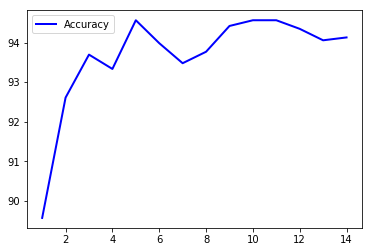

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
plotdata = pd.DataFrame({'Sensitivity': Sensitivity, 'Accuracy': Accuracy })
plt.plot( 'Sensitivity', 'Accuracy', data=plotdata, marker='', color='blue', linewidth=2)
plt.legend()

### <span style="color:blue">Conclusion</span>
###  If we can observe from the above results , accuracy is mostly increasing with the  sensitivity Parameter.  But after certain points it is stabilizing or oscillating in a smaller range 




# <span style="color:red">**Question 1(c)  - Plot the OOB (out-of-bag) error vs test error**</span>

In [22]:
test_errors = []
oob_erros= []
Variables = []
for i in list(range(1, 57)):
    clf = RandomForestClassifier(  max_features = i , oob_score=True)
    clf.fit(X_train , y_train)
    y_pred = clf.predict(X_test)
    test_error =  1- accuracy_score(y_test, y_pred)
    oob_error = 1- clf.oob_score_
    test_errors.append(test_error)
    oob_erros.append(oob_error)
    Variables.append(i)

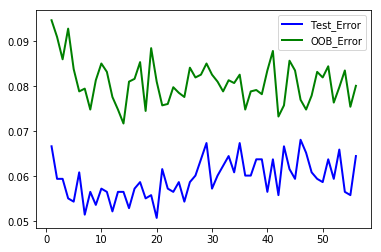

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
Test_vs_OOB=pd.DataFrame({'Number_of_Variables': Variables, 'Test_Error': test_errors, 'OOB_Error': oob_erros })
plt.plot( 'Number_of_Variables', 'Test_Error', data=Test_vs_OOB, marker='', color='blue', linewidth=2)
plt.plot( 'Number_of_Variables', 'OOB_Error', data=Test_vs_OOB, marker='', color='green', linewidth=2)
plt.legend()

### <span style="color:blue">Conclusion</span>

### As we can see , initially when the nnumber of features used for best split  is less  , OOB Error is quite high compare to the Test Error . But as we increase the number of features used for best split they approach much closer. 